In [25]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.transform import from_bounds
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from rasterio.mask import mask
from pathlib import Path
from rasterio.plot import show
%matplotlib inline
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
import elevation


# Task one 

### Data visualization and insights on Analysis of mangrove cover 



In [26]:
# Directory containing the TIFF files
directory = 'data_task_1'

# List all TIFF files in the directory
tiff_files = sorted([file for file in os.listdir(directory) if file.endswith('.tif')])
tiff_files

['gmw_2016.tif',
 'gmw_2017.tif',
 'gmw_2018.tif',
 'gmw_2019.tif',
 'gmw_2020.tif']

### Read ROI geojson file

<Axes: >

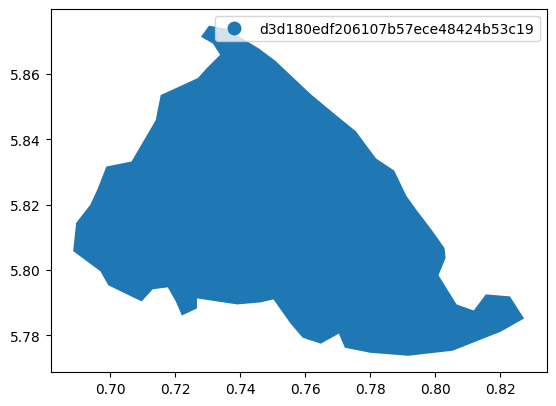

In [27]:
rio_layer_path = 'data_task_1/mangroves_case_study.geojson'
roi_gdf = gpd.read_file(rio_layer_path)
roi_gdf.plot(column="id", legend=True)

### Read raster usign Window method 
    1. Visualization
    2. Transformation
    3. Clip on the fly

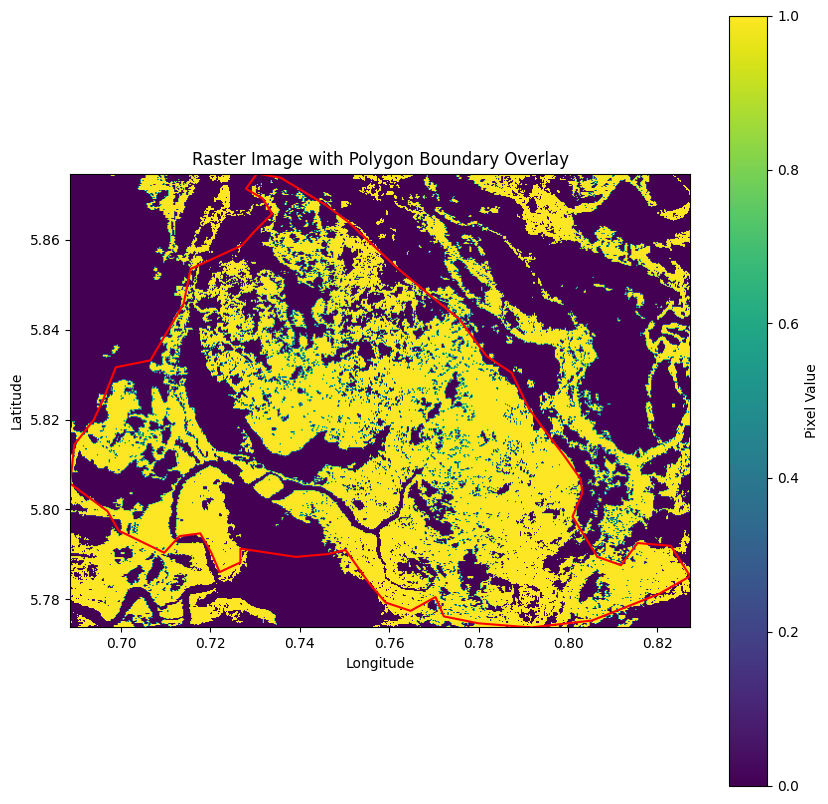

Clipped raster saved as: clipped_raster.tif


In [28]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.enums import Resampling

# Step 1: Read the GeoDataFrame from the shapefile
polygon_file = "data_task_1/mangroves_case_study.geojson"
gdf = gpd.read_file(polygon_file)

# Step 2: Open the TIFF file using rasterio
tiff_file = "data_task_1/gmw_2016.tif"

with rasterio.open(tiff_file) as src:
    # Step 3: Reproject the polygon layer to match the CRS of the TIFF file
    gdf_reprojected = gdf.to_crs(src.crs)

    # Step 4: Get the extent of the reprojected polygon
    polygon_extent = gdf_reprojected.total_bounds

    # Step 5: Read the window of the TIFF file based on the extent of the polygon
    window = src.window(*polygon_extent)
    window_transform = src.window_transform(window)

    data = src.read(window=window)

    # Step 6: Set the CRS and extent of the windowed TIFF file to match the polygon
    transform = from_bounds(*polygon_extent, width=data.shape[2], height=data.shape[1])
    profile = src.profile
    profile.update({
        'transform': transform,
        'width': data.shape[2],
        'height': data.shape[1],
        'crs': src.crs
    })

    # Plotting the raster image
    plt.figure(figsize=(10, 10))
    plt.imshow(data.transpose(1, 2, 0), extent=[polygon_extent[0], polygon_extent[2], polygon_extent[1], polygon_extent[3]])
    plt.colorbar(label='Pixel Value')

    # Overlaying the boundary of the polygon
    gdf_reprojected.boundary.plot(ax=plt.gca(), color='red')

    plt.title('Raster Image with Polygon Boundary Overlay')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

    # Clipping the raster image based on the polygon boundary
    clipped_data, clipped_transform = mask(src, gdf_reprojected.geometry, crop=True)

    # Update profile for the clipped raster
    profile.update({
        'transform': clipped_transform,
        'width': clipped_data.shape[2],
        'height': clipped_data.shape[1],
        'crs': src.crs
    })

    # Write the clipped raster to a new TIFF file
    # clipped_tiff_file = "clipped_raster.tif"
    # with rasterio.open(clipped_tiff_file, 'w', **profile) as dst:
    #     dst.write(clipped_data)

    print(f"Clipped raster saved as: {clipped_tiff_file}")


### Automating the process for all years

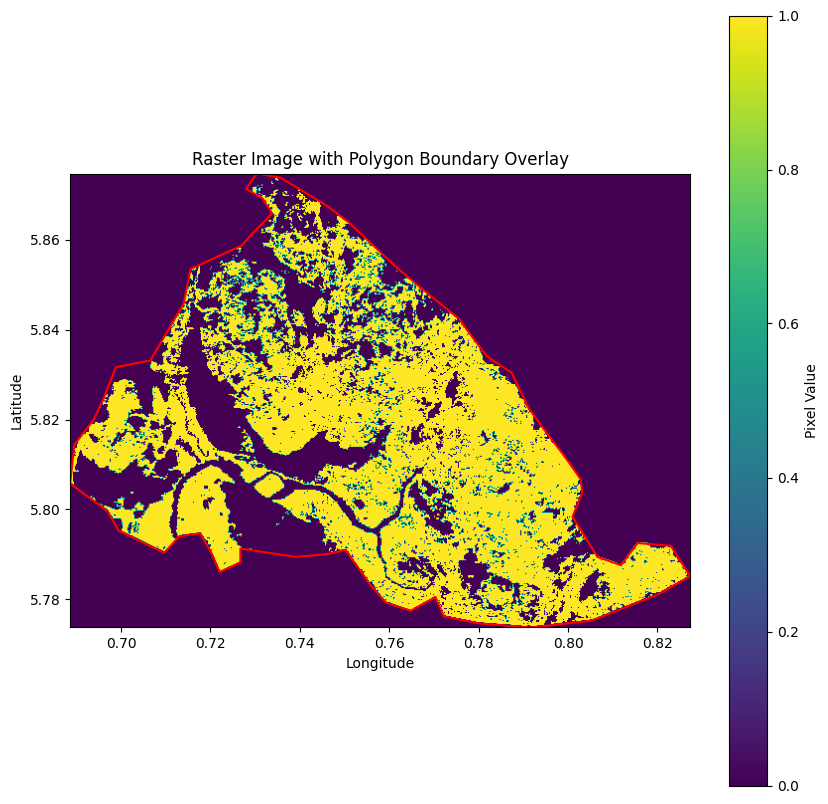

Clipped raster saved as: output/gmw_2016.tif _clipped.tif


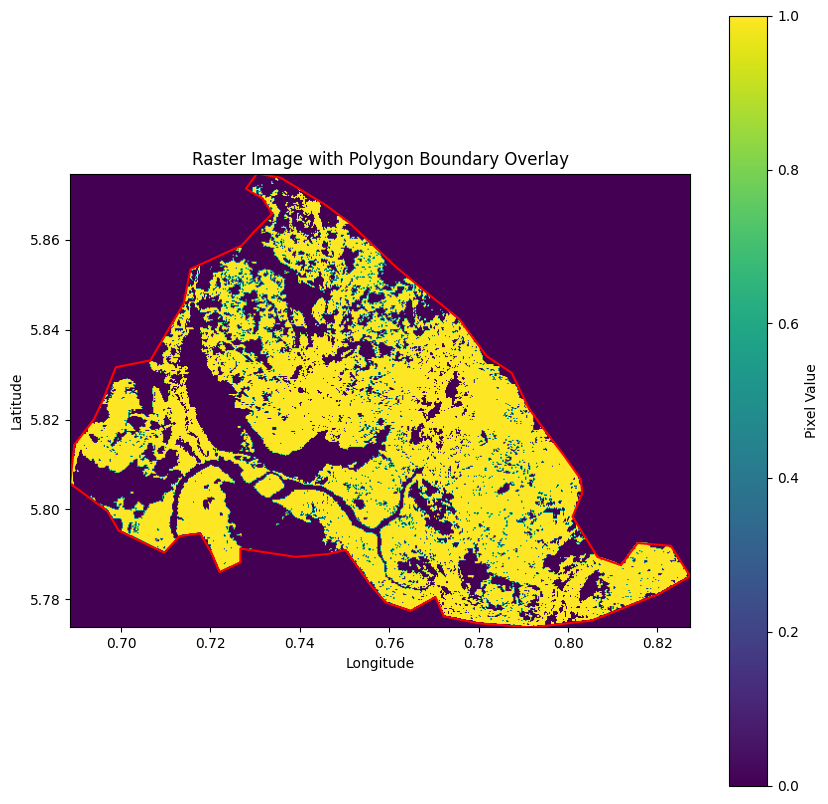

Clipped raster saved as: output/gmw_2017.tif _clipped.tif


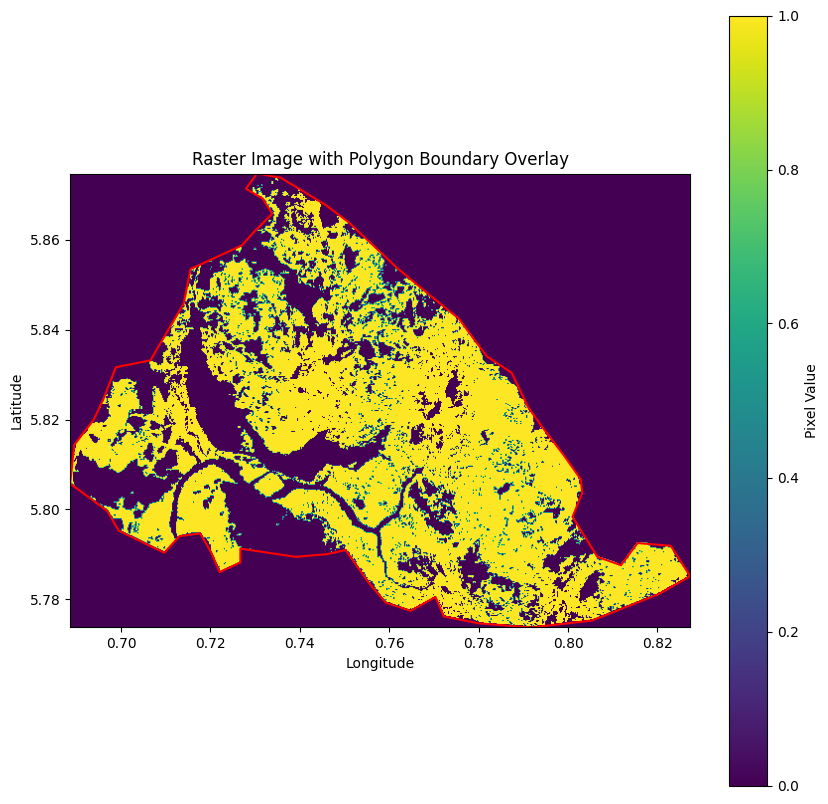

Clipped raster saved as: output/gmw_2018.tif _clipped.tif


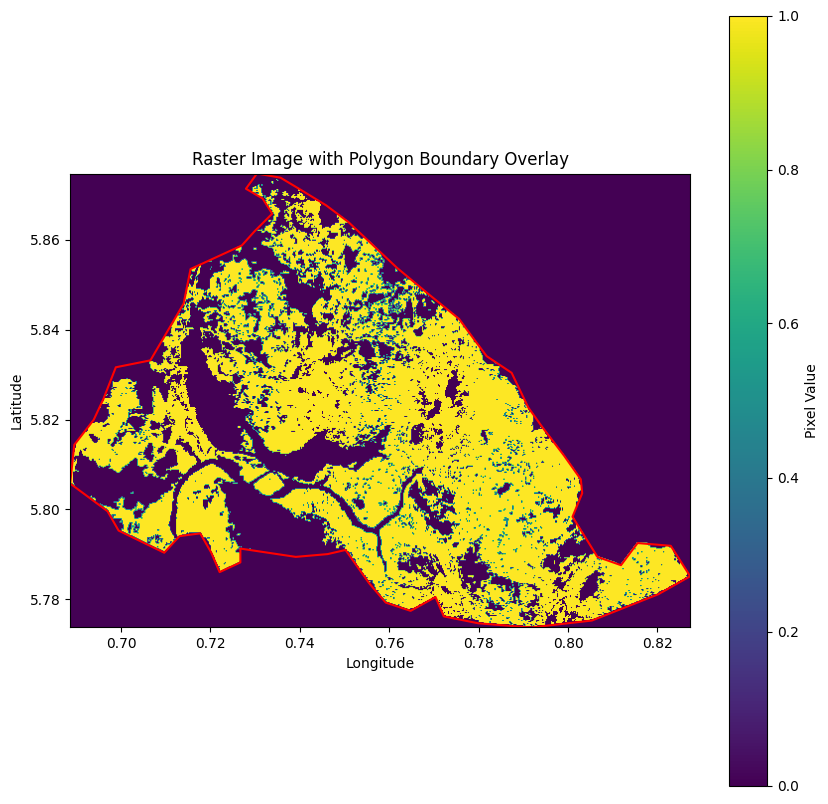

Clipped raster saved as: output/gmw_2019.tif _clipped.tif


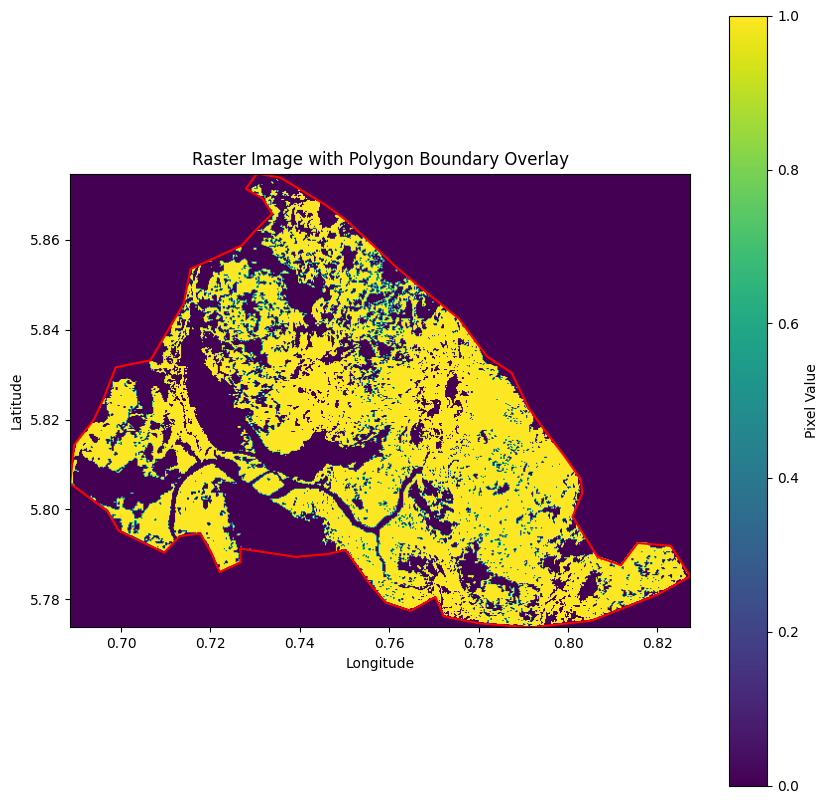

Clipped raster saved as: output/gmw_2020.tif _clipped.tif


In [29]:

path_to_roi_geopandas = "data_task_1/mangroves_case_study.geojson"
path_to_tif_files = "data_task_1"

def mangrove_tif_data_transformation(path_to_tif_files, path_to_roi_geopandas):
    
    ## Create the output directory
    Path("output").mkdir(parents=True, exist_ok=True)

    ## List all the tif files name
    tiff_files = sorted([file for file in os.listdir(path_to_tif_files) if file.endswith('.tif')])

    # Step 1: Read the ROI from the geojson
    polygon_file = path_to_roi_geopandas 
    gdf = gpd.read_file(polygon_file)

    # Step 2: Loop over each TIFF file and apply the required transformation using rasterio
    for tiff_file in tiff_files:

        input_tif_file = f'{path_to_tif_files}{"/"}{tiff_file}'

        with rasterio.open(input_tif_file) as src:
            # Step 3: Reproject the polygon layer to match the CRS of the TIFF file
            gdf_reprojected = gdf.to_crs(src.crs)

            # Step 4: Get the extent of the reprojected polygon
            polygon_extent = gdf_reprojected.total_bounds

            # Step 5: Read the window of the TIFF file based on the extent of the polygon
            window = src.window(*polygon_extent)
            window_transform = src.window_transform(window)

            data = src.read(window=window)

            # Step 6: Set the CRS and extent of the windowed TIFF file to match the polygon
            transform = from_bounds(*polygon_extent, width=data.shape[2], height=data.shape[1])
            profile = src.profile
            profile.update({
                'transform': transform,
                'width': data.shape[2],
                'height': data.shape[1],
                'crs': src.crs
            })


            # Clipping the raster image based on the polygon boundary
            clipped_data, clipped_transform = mask(src, gdf_reprojected.geometry, crop=True)

            # Update profile for the clipped raster
            profile.update({
                'transform': clipped_transform,
                'width': clipped_data.shape[2],
                'height': clipped_data.shape[1],
                'crs': src.crs
            })

            # Write the clipped raster to a new TIFF file

            tif_name = input_tif_file.split('/')[1]
            # output_tif_file_name = f'{tif_name} {"_clipped.tif"}'
            output_tif_file_name = f'{"output/"}{tif_name} {"_clipped.tif"}'


            with rasterio.open(output_tif_file_name, 'w', **profile) as dst:
                dst.write(clipped_data)


            # Plotting the raster image
            plt.figure(figsize=(10, 10))
            plt.imshow(clipped_data.transpose(1, 2, 0), extent=[polygon_extent[0], polygon_extent[2], polygon_extent[1], polygon_extent[3]])
            plt.colorbar(label='Pixel Value')

            # Overlaying the boundary of the polygon
            gdf_reprojected.boundary.plot(ax=plt.gca(), color='red')

            plt.title('Raster Image with Polygon Boundary Overlay')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.show()

            print(f"Clipped raster saved as: {output_tif_file_name}")

mangrove_tif_data_transformation(path_to_tif_files=path_to_tif_files, path_to_roi_geopandas=path_to_roi_geopandas)


### Data visualization-mangrove coverage distribution

In [30]:
import os
import rasterio
import numpy as np
import plotly.graph_objs as go

mangrove_coverage_clipped_tiff_files = sorted([file for file in os.listdir("output") if file.endswith('.tif')])

# Function to read raster dataset and extract mangrove coverage values
def read_raster(filename):
    with rasterio.open(f'{"output/"}{filename}') as src:
        mangrove_coverage = src.read(1)  # Assuming mangrove coverage is in the first band
        return mangrove_coverage

# Read raster datasets for each year and extract mangrove coverage
mangrove_data = [read_raster(filename) for filename in mangrove_coverage_clipped_tiff_files]

# Create Plotly traces for each year's mangrove coverage
frames = []
for i, year in enumerate(range(2016, 2021)):
    frame = go.Frame(data=[
        go.Heatmap(z=mangrove_data[i],
                   zmin=0, zmax=1,  # Assuming values are binary (0 and 1)
                   colorscale='Viridis',
                   name=str(year))
    ], name=str(year))
    frames.append(frame)

# Create the animation
fig = go.Figure(
    data=[go.Heatmap(z=mangrove_data[0], zmin=0, zmax=1, colorscale='Viridis', name=str(2016))],
    layout=go.Layout(
        title="Mangrove Coverage Changes Over Time",
        xaxis_title="Longitude",
        yaxis_title="Latitude",
        updatemenus=[{
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 500, "redraw": True},
                                    "fromcurrent": True, "transition": {"duration": 300,
                                                                        "easing": "quadratic-in-out"}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate",
                                      "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }],
        sliders=[{
            "active": 0,
            "yanchor": "top",
            "xanchor": "left",
            "currentvalue": {
                "font": {"size": 20},
                "prefix": "Year:",
                "visible": True,
                "xanchor": "right"
            },
            "transition": {"duration": 300, "easing": "cubic-in-out"},
            "pad": {"b": 10, "t": 50},
            "len": 0.9,
            "x": 0.1,
            "y": 0,
            "steps": [{"args": [[str(year)], {"frame": {"duration": 300, "redraw": True},
                                              "mode": "immediate"}],
                       "label": str(year),
                       "method": "animate"} for year in range(2016, 2021)]
        }]
    ),
    frames=frames
)

# Save the animation as an HTML file
plotly_html_path = "mangrove_coverage_animation.html"
fig.write_html(plotly_html_path, auto_open=False)

# Display the animation using an iframe
from IPython.display import IFrame
IFrame(src=plotly_html_path, width="100%", height=600)


In [31]:
import plotly.graph_objs as go
import numpy as np
from IPython.display import IFrame

# Assuming you have a list of 5 arrays where each array represents mangrove coverage for a specific year
# Each array has a shape of (456, 625)
# For demonstration purposes, let's create a sample list of arrays with random data
mangrove_coverage_arrays = mangrove_data

# Create empty lists to store x and y data for each year
x_data = []
y_data = []
for year, arr in enumerate(mangrove_coverage_arrays, start=2016):
    # Calculate the sum of elements with a value of 1 for each year
    mangrove_coverage_sum = np.sum(arr == 1)
    # Append x and y data for the current year
    x_data.append(year)
    y_data.append(mangrove_coverage_sum)

# Create a Plotly trace for the summarized mangrove coverage
trace = go.Scatter(
    x=x_data,  # Years
    y=y_data,  # Mangrove coverage sums for each year
    mode='markers+lines',
    name='Mangrove Coverage',
    line=dict(width=2),
    marker=dict(size=8)
)

# Create a Plotly figure with the trace
fig = go.Figure(data=[trace])

# Update layout
fig.update_layout(
    title='Summarized Mangrove Coverage Over Time',
    xaxis_title='',  # Empty string to remove the x-axis title
    yaxis_title='Sum of Mangrove Coverage',
    xaxis=dict(type='category', showticklabels=False),
)

# Add a slider to the figure for selecting the year
fig.update_layout(
    sliders=[{
        'active': 0,
        'steps': [{'label': str(year), 'method': 'update', 'args': [{'x': [x_data[:year-2016+1]], 'y': [y_data[:year-2016+1]]}]} for year in range(2016, 2021)],  # Adjusted range from 2016 to 2020
    }]
)

# Save the animation as an HTML file
plotly_html_path = "mangrove_coverage_animation.html"
fig.write_html(plotly_html_path, auto_open=False)

# Display the HTML file using an iframe
IFrame(src=plotly_html_path, width="100%", height=600)

## Summary
Summarise the findings with a concise textual description. This summary will serve as a template for future automated reporting by our AI, Maya.


The plots above show that the total mangrove coverage increased over the years from 2016 to 2018, but then decreased sharply in 2019 and 2020. Here are the total mangrove coverage numbers for each year:

- 2016: 89,281
- 2017: 90,721 
- 2018: 91,904
- 2019: 90,694
- 2020: 87,614

These numbers represent the total area covered by mangroves for each respective year. Overall, there was a positive trend in mangrove coverage until 2018, followed by a notable decline in 2019 and 2020.

# Task two

### Quantify coastal flood risks focusing on cost-efficiency and relevance to the client’s needs.

### Here are some datasets that could be suitable for evaluating flood risks

- Historical flood data
- sea level rise projections
- Digital Elevation Model
- Mangrove distribution
-  

# Data Visualization

### Digital Elevation Model

##### Download DEM SRTM1 for 30m resolutionfrom NASA using python

[Sampel Notebook]('https://geographicdata.science/book/data/nasadem/build_nasadem_sd.html')

In [32]:
rio_layer_path = 'data_task_1/mangroves_case_study.geojson'
dem_path_to_store = 'data_task_2/mangrove_DEM.tif'

def read_roi_boundary(rio_layer_path):
    roi_gdf = gpd.read_file(rio_layer_path)
    return roi_gdf


def get_srtm_dem_30m(rio_layer_path, dem_path_to_store):
    '''
    Using elevation package to extract Digital Elevation Model (DEM) with 30m spatial resolution from NASA and store it into the local mahcine as GeoTiff.
    '''
    # Read roi_bounday
    roi_gdf = read_roi_boundary(rio_layer_path)    
    # Define a bounding box
    bounds = roi_gdf.bounds
    # Split the list into separate variables
    west, south, east, north = bounds = bounds.loc[0]

    # Let's add 3" in every direction before we request the DEM to the server. 
    # This is important because, when we reproject the DEM from latlong to UTM, 
    # the data is translated, rotated and rescaled by an Affine matrix and we usually end up with missing information on the corners
    # unless we select a bigger rectangle, and that's basically what we are doing here. Try skipping this line and continue the process.
    west, south, east, north = bounds  = west - .05, south - .05, east + .05, north + .05

    output = os.getcwd() + "/" + dem_path_to_store
    
    # Call the elevation method to download and clip the SRTM dataset according to the bounds we define above. 
    elevation.clip(bounds=bounds, output=output, product='SRTM1') 
    print('DEM was downloaded successfully')


get_srtm_dem_30m(rio_layer_path=rio_layer_path, dem_path_to_store=dem_path_to_store)


make: Nothing to be done for `download'.
make: Nothing to be done for `all'.
cp SRTM1.vrt SRTM1.0b16bb779e6840c4bf355980b1d44cea.vrt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 0.6386072135718279 5.924766036594266 0.8773310504954452 5.72372468017029 SRTM1.0b16bb779e6840c4bf355980b1d44cea.vrt /Users/bx2a428/projects/interview/maya_geospatial_engineer_case_study/data_task_2/mangrove_DEM.tif
rm -f SRTM1.0b16bb779e6840c4bf355980b1d44cea.vrt
DEM was downloaded successfully


### Visualize the downloaded DEM data

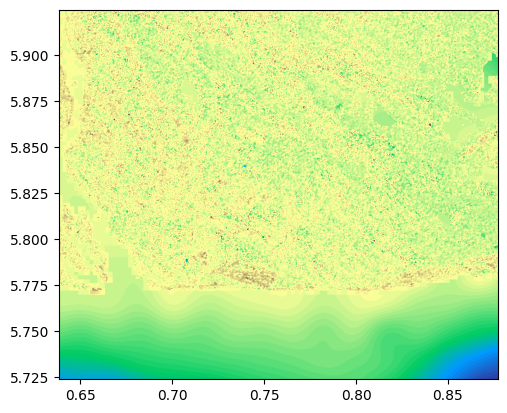

<Axes: >

In [33]:
raster_file = "/Users/bx2a428/projects/interview/maya_geospatial_engineer_case_study/data_task_2/mangrove_DEM.tif"
# Read the GeoTiff file from disk
raster_data = rasterio.open(raster_file)
# Plot the raster
show(raster_data, cmap='terrain')

### Transform the DEM data

In [34]:

### Set directories
rio_layer_path = 'data_task_1/mangroves_case_study.geojson'
input_tif_dir = "/Users/bx2a428/projects/interview/maya_geospatial_engineer_case_study/data_task_2/mangrove_DEM.tif"
output_tif_name = "mangrove_DEM"




def read_roi_boundary(rio_layer_path):
    roi_gdf = gpd.read_file(rio_layer_path)
    return roi_gdf



def transform_raster_data(path_to_tif, rio_layer_path, output_tif_name):
    '''
    Transfer input raster image and store the result into the target directory
    '''

    # Read roi_bounday
    roi_gdf = read_roi_boundary(rio_layer_path)
    
    with rasterio.open(path_to_tif) as src:
        # Reproject the polygon layer to match the CRS of the TIFF file
        gdf_reprojected = roi_gdf.to_crs(src.crs)
    
        # Get the extent of the reprojected polygon
        polygon_extent = gdf_reprojected.total_bounds
    
        # Read the window of the TIFF file based on the extent of the polygon
        window = src.window(*polygon_extent)
        window_transform = src.window_transform(window)
    
        data = src.read(window=window)
    
        # Set the CRS and extent of the windowed TIFF file to match the polygon
        transform = from_bounds(*polygon_extent, width=data.shape[2], height=data.shape[1])
        profile = src.profile
        profile.update({
            'transform': transform,
            'width': data.shape[2],
            'height': data.shape[1],
            'crs': src.crs
        })
    
    
        # Clipping the raster image based on the polygon boundary
        clipped_data, clipped_transform = mask(src, gdf_reprojected.geometry, crop=True)
    
        # Update profile for the clipped raster
        profile.update({
            'transform': clipped_transform,
            'width': clipped_data.shape[2],
            'height': clipped_data.shape[1],
            'crs': src.crs
        })

        # Write the clipped raster to a new TIFF file
        output_tif_file_name = f'{"output/"}{output_tif_name}{"_clipped.tif"}'
    
        with rasterio.open(output_tif_file_name, 'w', **profile) as dst:
            dst.write(clipped_data)
    
        print(f'Raster was transformed successfully and stored as {output_tif_name}{"_clipped.tif"}')


### Run the method
transform_raster_data(path_to_tif=input_tif_dir, rio_layer_path=rio_layer_path, output_tif_name=output_tif_name)


Raster was transformed successfully and stored as mangrove_DEM_clipped.tif


### Visualize the transformed DEM

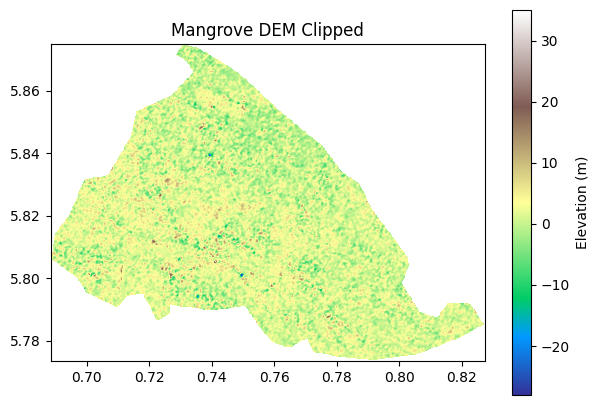

In [38]:
# Read the GeoTiff file from disk
raster_data = rasterio.open("output/mangrove_DEM_clipped.tif")

# Plot the raster data
plt.figure(figsize=(7, 5))
ax = plt.gca()
img = show(raster_data, cmap='terrain', ax=ax)  # Plot the raster data

# Manually calculate the color limits
data = raster_data.read(1, masked=True)  # Read the raster data
vmin, vmax = data.min(), data.max()  # Calculate the min and max values from the data

norm = Normalize(vmin=vmin, vmax=vmax)
mappable = plt.cm.ScalarMappable(norm=norm, cmap='terrain')
mappable.set_array(data)  # Set the array for the colorbar
plt.colorbar(mappable, ax=ax, label='Elevation (m)')  # Add colorbar to the plot
plt.title('Mangrove DEM Clipped')  # Add a title to the plot
plt.show()


### 2. Sea level rise projections

[Sea level rise projection data source]('https://sealevel.nasa.gov/ipcc-ar6-sea-level-projection-tool')



In [39]:
import pandas as pd

# Specify the path to the Excel file
excel_file = "data_task_2/ipcc_ar6_sea_level_projection_psmsl_id_1049.xlsx"

# Specify the sheet name or index you want to read
sheet_name = "GIS"  # Change this to the name of the sheet you want to read
# Alternatively, you can use sheet index (0-indexed) like sheet_index = 0

# Read the specified sheet into a pandas DataFrame
df = pd.read_excel(excel_file, sheet_name=sheet_name)

# Display the DataFrame
df.head()

,psmsl_id,process,confidence,scenario,quantile,2020,2030,2040,2050,2060,2070,2080,2090,2100,2110,2120,2130,2140,2150
0,1049,GIS,medium,ssp119,5,0.004,0.007,0.007,0.010,0.009,0.006,-0.001,-0.007,-0.033,0.032,0.036,0.041,0.046,0.050
1,1049,GIS,medium,ssp119,17,0.004,0.009,0.011,0.017,0.018,0.019,0.017,0.017,0.002,0.050,0.056,0.063,0.068,0.074
2,1049,GIS,medium,ssp119,50,0.006,0.012,0.017,0.025,0.030,0.037,0.043,0.048,0.045,0.069,0.077,0.085,0.093,0.101
3,1049,GIS,medium,ssp119,83,0.007,0.015,0.023,0.035,0.043,0.057,0.071,0.085,0.092,0.088,0.099,0.109,0.120,0.130
4,1049,GIS,medium,ssp119,95,0.008,0.019,0.030,0.045,0.059,0.078,0.100,0.119,0.141,0.106,0.119,0.132,0.146,0.160


In [40]:
# Specify the columns you want to keep
desired_columns = ["scenario", 2020,2030,2040,2050,2060,2070,2080,2090,2100,2110,2120,2130,2140,2150]

# Filter the DataFrame to keep only the desired columns
filtered_df = df[desired_columns]
filtered_df.head()

,scenario,2020,2030,2040,2050,2060,2070,2080,2090,2100,2110,2120,2130,2140,2150
0,ssp119,0.004,0.007,0.007,0.010,0.009,0.006,-0.001,-0.007,-0.033,0.032,0.036,0.041,0.046,0.050
1,ssp119,0.004,0.009,0.011,0.017,0.018,0.019,0.017,0.017,0.002,0.050,0.056,0.063,0.068,0.074
2,ssp119,0.006,0.012,0.017,0.025,0.030,0.037,0.043,0.048,0.045,0.069,0.077,0.085,0.093,0.101
3,ssp119,0.007,0.015,0.023,0.035,0.043,0.057,0.071,0.085,0.092,0.088,0.099,0.109,0.120,0.130
4,ssp119,0.008,0.019,0.030,0.045,0.059,0.078,0.100,0.119,0.141,0.106,0.119,0.132,0.146,0.160


In [42]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py
from IPython.display import IFrame

# Create traces for each scenario
fig = make_subplots(rows=1, cols=1)
buttons = []
for scenario in filtered_df['scenario'].unique():
    scenario_data = filtered_df[filtered_df['scenario'] == scenario]
    trace = go.Scatter(x=scenario_data.columns[1:], y=scenario_data.iloc[0, 1:], mode='lines+markers', name=f'Scenario {scenario}')
    fig.add_trace(trace)

    button = dict(method='update', label=f'Scenario {scenario}',
                  args=[{'y': [scenario_data.iloc[0, 1:]]}])
    buttons.append(button)

fig.update_layout(
    updatemenus=[dict(active=0, buttons=buttons)],
    title='Sea Level Changes Over Time for Different Scenarios',
    xaxis_title='Year',
    yaxis_title='Sea Level Change'
)

# Save the Plotly figure as an HTML file
html_filename = 'interactive_plot.html'
py.plot(fig, filename=html_filename, auto_open=False)

# Display the HTML file using IFrame
IFrame(src=html_filename, width='100%', height=600)